# TP3: Triangulation de Delaunay

Dans ce TP on se propose de recoder un algorithme permettant d'obtenir la triangulation de Delaunay d'un ensemble de points en 2D. Bien que cet algorithme soit disponible dans les modules matplotlib et scipy, il y a un intérêt pédagogique à reprendre ses grandes étapes, représentatives d'un algorithme géométrique.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## Boîte englobante

1.Ecrire une fonction qui renvoie la boîte englobante d'un ensemble de points en 2D de coordonnées $(X_i,Y_i)$. La fonction doit renvoyer les quatre sommets d'un rectangle contenant les points et dont les coordonnées sont obtenues en combinant ensemble $m_X=\min_i(X_i)$, $M_X=\max_i(X_i)$ avec $m_Y=\min_i(Y_i)$, $M_Y=\max_i(Y_i)$.
Vous ajouterez aussi, comme en cours, $\pm \epsilon_x$ et $\pm \epsilon_y$.

In [2]:
def boiteEnglobante(X,Y,ex=0.1,ey=0.1):
    """
    X list of point coordenates in x axis
    Y list of point coordinates in y axis
    ex: padding in x axis
    ey: padding in y axis
    function returns a list of four points englobing 
    input points in bidimentional space
    """
    
    # Get min and max values for each coordinate
    mx = np.min(X)
    Mx = np.max(X)
    my = np.min(Y)
    My = np.max(Y)
    
    # Add margin values and return
    return np.array([[mx-ex,my-ey],[Mx+ex,my-ey],[Mx+ex,My+ey],[mx-ex,My+ey]])

2.Vérifiez, par la visualisation graphique, que vos programmes fonctionnent bien avec des poins aléatoires ou des figures géométriques plus simples comme des carrés

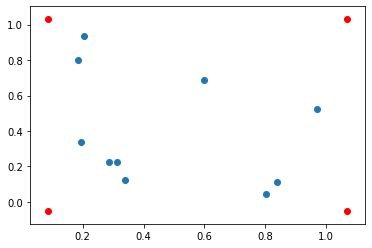

In [65]:
# Create 10 random points
points= np.random.rand(10,2)

# Create box
bords = boiteEnglobante(points[:,0],points[:,1])

# Plot points
plt.scatter(points[:,0],points[:,1])
plt.scatter(bords[:,0],bords[:,1],color='r')
plt.show()

## Fonctions auxiliaires

Dans la suite il vous sera peut-être utile de disposer des fonctions de visualisation suivantes qui vous permettront de vérifier que vos fonctions auxiliaires font ce qu'elles doivent faire.

In [70]:
# Affichage de triangles et d'un texte au centre de gravité

def affichageTriangle(Tri,coords,texte='',col=False):
    A=coords[Tri[0],:]
    B=coords[Tri[1],:]
    C=coords[Tri[2],:]
    if col:
        couleur='magenta'
        plt.plot([A[0],B[0]],[A[1],B[1]],color=couleur)
        plt.plot([A[0],C[0]],[A[1],C[1]],color=couleur)
        plt.plot([C[0],B[0]],[C[1],B[1]],color=couleur)
    else:
        plt.plot([A[0],B[0]],[A[1],B[1]])
        plt.plot([A[0],C[0]],[A[1],C[1]])
        plt.plot([C[0],B[0]],[C[1],B[1]])
    plt.text((A[0]+B[0]+C[0])/3,(A[1]+B[1]+C[1])/3,texte)
    
def affichageTousTriangles(Tri,coords,col=False):
    for T in Tri:
        affichageTriangle(T,coords,'',col)
        
def affichagePartieTriangles(listeTri,Tri,coords,col=False):
    for t in listeTri:
        T=Tri[t,:]
        affichageTriangle(T,coords,str(t),col)

4.Ecrire une fonction qui donne parmi les triangles déjà construits (Tri) ceux ne vérifiant pas la condition de Delaunay pour un nouveau point à ajouter (point). Vous utiliserez aussi la fonction estDansCirconscrit qui a été introduite au précédent TP.

In [71]:

def centreCercleCirconscrit(coords):
    """
    coords: bidimentional point list
    returns center point and radius of circonscribed circle
    """
    A = coords[0]
    B = coords[1]
    C = coords[2]
    
    T = np.array([[B[0] -A[0],B[1]-A[1]],[C[0]-A[0],C[1]-A[1]]])
    K = np.array([B[0]**2+B[1]**2-A[0]**2 -A[1]**2,C[0]**2+C[1]**2-A[0]**2 -A[1]**2])
    x = np.linalg.solve(T, K/2)
    r = np.linalg.norm(x-B)

    return x,r

def estDansCirconscrit(point,coords):
    """
    point: point to see if exists in circle
    coords: coordinates of triangle
    """
    
    # Get center and radius of circle
    center , radix = centreCercleCirconscrit(coords)
    
    # Returns boolean variable
    return(np.linalg.norm(point-center)<=radix)


def triSupprimer(point,Tri,Coords):
    """ 
     -point: coordonnées d'un point à ajouter
     -Tri: triangulation existante
     -Coords: coordonnées des points de la triangulation
     Sorties: 
     -triASupprimer: liste d'indices de triangles de Tri dont le cercle circonscrit contient point
    """
    triAsupprimer = []
    
    # For each triangle
    for i in range(len(Tri)): 
        
        # Check if the point is in the circonscribed circle
        if estDansCirconscrit(point,Coords[Tri[i],:]):
            
            # Append to lis if yes
            triAsupprimer.append(i)
    
    return(np.array(triAsupprimer))


    
    

5.Ecrire une fonction qui renvoie les nouveaux triangles de la triangulation après réorganisation des triangles à supprimer, relativement à un point d'indice i et de coordonnées point. Vous utiliserez la fonction triAnglePolaire introduite au TP2.

In [79]:
def triAnglePolaire(coords,point):

    res = np.zeros(len(coords))
    for i in range(len(coords)):
        vector = np.array([coords[i,0]-point[0],coords[i,1]-point[1]])
        z = complex(vector[0],vector[1])
        res[i] = np.angle(z,deg=True)
        
    return res

def triAjouter(i,point,triASupprimer,Tri,Coords):
    """Entrées: 
     -i: indice d'un point à ajouter à Tri
     -point: coordonnées du point à ajouter
     -triASupprimer: triangles à supprimer
     -Tri: triangulation existante
     -Coords: coordonnées des points de la triangulatio
    
     Sorties: 
     -triAAjouter: tableau (p x 3) de nouveaux triangles à ajouter à la triangulation Tri
    """
    # 1. Récupérer les sommets (s_j) des triangles à supprimer
    triAAjouter = []
    s = np.unique(Tri[triASupprimer,:].flatten())
    # 2. Ordonner les sommets par valeur croissante de l'angle polaire formée par le vecteur (point,sommet)
    # et l'axe des abscisses. Utillisez la fonction triAnglePolaire du TP2
    
    center = [0,0]
    polar_angs = triAnglePolaire(Coords[s],point)
    ind = np.argsort(polar_angs)
    Coords = Coords[ind]
    polar_angs = polar_angs[ind]

    s = s[ind]
    s = np.hstack((s, s[0]))
    # 3. Parcourir les sommets ordonnés, et ajouter les triangles (i,s_j,s_{j+1}) à triAAjouter
    for j in range(len(s)-1):
        triAAjouter.append([i,s[j],s[j+1]])
    return(np.array(triAAjouter))
    

## Fonction principale
6.Ecrire enfin la fonction qui assemble les différentes étapes élémentaires. On donne ici l'en-tête et les principales étapes

In [80]:
def myDelaunay(X,Y):
    # Entrées: X,Y coordonnées de n points en 2D
    #
    # Sorties: 
    # -Tri: triangulation de Delaunay des points en entrée auxquels 
    # on ajoute éventuellement de 0 à 4 points de la boîte englobante
    # -Coords: coordonnées des points triangulés
    
    n=X.shape[0] #nombre de points
    
    # 1. Calcul de la boite englobante des points
    Coords = boiteEnglobante(X,Y)
    
    plt.scatter(points[:,0],points[:,1])
    plt.scatter(bords[:,0],bords[:,1],color='r')
    plt.show()
    # 2. Triangulation initiale (Tri), Points initiaux (Coords). 
    # Obtenus avec les 4 points de la boîte englobante
    Tri = np.array([[0,1,2],[0,2,3]])
    
    # 3. Enlever les points éventuels de la boîte de X et Y
    
    # 4. Parcours des points restants (X,Y)

    for i in range(n):
        # 1) triangles à supprimer
        point = np.array([X[i],Y[i]])

        triAsupprimer = triSupprimer(point,Tri,Coords)
        # 2) triangles à rajouter
        triAjoutes = triAjouter(i+4,point,triAsupprimer,Tri,Coords)

        # 3) Mise à jour de Tri et Coords
        # - Utiliser les méthodes delete et concatenate de numpy
        Coords = np.vstack((Coords,point))

        Tri = np.vstack((Tri,triAjoutes))

        Tri2 = np.delete(Tri,triAsupprimer,axis=0)
        Tri  = Tri2

        #plt.figure()
        #affichageTousTriangles(Tri,Coords,col=False)



    return(Tri,Coords)

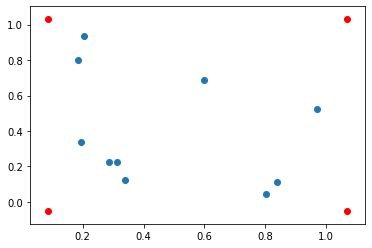

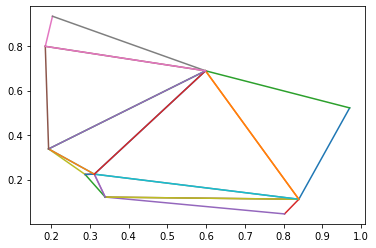

In [81]:
tri,coords = myDelaunay(points[:,0],points[:,1])

#affichageTousTriangles(tri,coords,col=False)

del_list = [0,1,2,3]
final = []
for i in tri:
    flag = 1
    for k in i:
        if k in del_list:
            flag=0
            
    if flag:
        final.append(list(i))
            

affichageTousTriangles(final,coords,col=False)